# Churn Case

In [2]:
# import the required packages
import pandas as pd 
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, confusion_matrix

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras

# Load the dat

# 1. Data Exploration

This part reads in the data as well as does some small exploration. But feel free to do some further exploration.

In [3]:
# import all the datasets
extrel = pd.read_csv("./data/extrel.csv")
extrelty = pd.read_csv("./data/extrelty.csv")
communication = pd.read_csv("./data/communication.csv")
payhistory = pd.read_csv("./data/payhistory.csv")
nameaddr = pd.read_csv("./data/nameaddr.csv")
comclas = pd.read_csv("./data/comclas.csv")
commediu = pd.read_csv("./data/commediu.csv")

In [4]:
# inspect dtypes of columns
extrel.dtypes

EXTRELNO       int64
EXRELACTCD    object
EXTRELSTDT    object
EXRELDATEN    object
dtype: object

In [5]:
# inspect first observation extrel
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
2,26424,FP,2005-02-26,2009-12-21
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT


In [6]:
# get the most recent date of the end dates of the relationships
extrel['EXRELDATEN'] = pd.to_datetime(extrel['EXRELDATEN'], format="%Y-%m-%d")
print(extrel['EXRELDATEN'].max())

# get the most recent date of the start dates of the relationships
extrel['EXTRELSTDT'] = pd.to_datetime(extrel['EXTRELSTDT'], format="%Y-%m-%d")
print(extrel['EXTRELSTDT'].max())

2040-10-27 00:00:00
2020-01-29 00:00:00


In [7]:
# inspect dtypes of columns
extrel.dtypes

EXTRELNO               int64
EXRELACTCD            object
EXTRELSTDT    datetime64[ns]
EXRELDATEN    datetime64[ns]
dtype: object

In [8]:
extrel.shape

(26689, 4)

In [9]:
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
2,26424,FP,2005-02-26,2009-12-21
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT


In [10]:
extrel.columns

Index(['EXTRELNO', 'EXRELACTCD', 'EXTRELSTDT', 'EXRELDATEN'], dtype='object')

In [11]:
extrel["EXRELACTCD"].value_counts()

EXRELACTCD
FP    11442
PS    10677
CT     3325
MR     1110
TR       45
AP       37
SP       13
PF        9
OR        7
PV        5
PO        5
GR        4
OI        4
RV        2
PP        2
PT        1
BM        1
Name: count, dtype: int64

In [12]:
## Missing Values
extrel.isna().sum()

EXTRELNO          0
EXRELACTCD        0
EXTRELSTDT        0
EXRELDATEN    16521
dtype: int64

In [13]:
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
2,26424,FP,2005-02-26,2009-12-21
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT


## 2. Time Window

Let's first define the time window by storing all the **relevant dates** as datetime objects.

In [14]:
# First, define the purpose model.
# The model will be used to predict customers' churn using today's data: END INDEPENDENT: October 25, 2023
# Churn is approximated over 1 year starting from january next year

# Purpose Model

#------------INDEPENDENT----------|xxxxGAPxxxxxx|------DEPENDENT-------|
#                            25/10/2023    01/01/2024             31/12/2024

# Next, we can define the model building part of the timewindow based on the purpose model.
# Data is available until March 2, 2020 (i.e. data dump received).
# End Dep period purpose model <= Available data (Your dependent period needs data input to be able to train a model)
# 31/12/?? <= 02/03/2020         Thus, this becomes: 31/12/2019

# Model Building
#
#------------INDEPENDENT----------|xxxxGAPxxxxxx|------DEPENDENT-------|
#                            25/10/2018    01/01/2019             31/12/2019

# define the model building time window

end_independent = datetime.strptime('25/10/2018', '%d/%m/%Y')
start_dependent = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_dependent = datetime.strptime('31/12/2019', '%d/%m/%Y')



# 3. Data Preparation

## 3.1. Customers

Subset the **extrel** dataset according to the appropriate time window. Remember, we are trying to predict which donors will churn. This means that we are not interested in donors who already left or who are no donors yet. Thus, take into account the following:

    a.	The start of the relationship should be before (or equal to) the end of the independent period.
    b.	The end of the relationship should be later than the start of the dependent period (or missing)

In [15]:
# first change EXTRELSTDT & EXRELDATEN to date type
extrel['EXTRELSTDT'] = pd.to_datetime(extrel['EXTRELSTDT'], format="%Y-%m-%d")
extrel['EXRELDATEN'] = pd.to_datetime(extrel['EXRELDATEN'], format="%Y-%m-%d")

In [16]:
# subset according to time window
customers = extrel[(extrel['EXTRELSTDT'] <= end_independent) 
                   & ((extrel['EXRELDATEN'] >= start_dependent) | (extrel["EXRELDATEN"].isnull()))]

# check
customers.head()



,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT
5,26431,FP,2005-02-26,NaT


## 3.2. Independent Variables

### 3.2.1. Independent information

Create the following **independent variables**. People with similar features are assumed to show similar behavior. Different kinds of features are used. In classical churn models, there are **two main types of features**: behavioral features and demographics. **Three predictors** have shown to be key in predicting customer churn in previous work: `recency`, `frequency` and `monetary value`. When we think back at our purpose model, we can only use information that is available at the end of our **independent period**. Therefore, make sure you use only information available at the end of the independent period :
 
<ol type="a">
  <li><strong>Frequency</strong>: how often a donor has donated during the independent period.</li>
  <li><strong>Recency</strong>: time (in days) since the last donation</li>
  <li><strong>Monetary Value</strong>: Total and average donation per donor</li>
  <li><strong>Paytype per customer</strong>: Create new variables that signify whether a donor ever used sendout, order, own initiative and unknown</li>
  <li>Preferred mailing language</li>
  <li><strong>Dummy</strong> whether the donor ever uttered a complaint (CLASCODE)</li>
  <li><strong>Dummy</strong> whether communication direction was ever incoming (CONTDIREC)</li>
</ol>

For creating the independent variables such as **recency**, **frequency**, **monetary value** (i.e., RFM) etc, we first need to make sure that we will only use information **during the independent period**.

In [17]:
# show transaction data set (PAYHISTORY)
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [18]:
# convert PDATE to datetime object
payhistory["PDATE"] = pd.to_datetime(payhistory["PDATE"], format='%Y-%m-%d')

In [19]:
# extract only those transactions which were made before the end of the independent period
payhistory_ind = payhistory[payhistory["PDATE"] <= end_independent]

In [20]:
# sort transactions by extrelno and pdate
payhistory_ind = payhistory_ind.sort_values(by=["EXTRELNO", "PDATE"])

In [21]:
# check
payhistory_ind.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


Now do the same for the **communication** data set.

In [22]:
communication.head()



,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,405402,CI,CTS,CT,20,O,2007-05-06
1,430904,CI,CTS,CT,20,O,2007-06-11
2,592732,CI,CTS,CT,20,O,2007-10-18
3,593375,CI,CTS,CT,20,O,2007-10-18
4,618514,CI,CTS,CT,20,O,2007-11-25


In [23]:
communication.dtypes

CONTID         int64
MEDIUMCODE    object
MNTOPCODE     object
CLASCODE      object
EXTRELNO       int64
CONTDIREC     object
CONTDATE      object
dtype: object

In [24]:
# convert CONTDATE  to datetime
communication["CONTDATE"] = pd.to_datetime(communication["CONTDATE"], format='%Y-%m-%d')

In [25]:
# extract only those communication which were made before the end of the independent period
communication_ind = communication[communication["CONTDATE"]<= end_dependent]

In [26]:
# sort transactions by extrelno and contdate
communication_ind = communication_ind.sort_values(by=["EXTRELNO", "CONTDATE"])

In [27]:
# check
communication_ind.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,405402,CI,CTS,CT,20,O,2007-05-06
1,430904,CI,CTS,CT,20,O,2007-06-11
2,592732,CI,CTS,CT,20,O,2007-10-18
3,593375,CI,CTS,CT,20,O,2007-10-18
4,618514,CI,CTS,CT,20,O,2007-11-25


### 3.2.2. Frequency

**Frequency**: the number of transactions made by a customer during the independent period

In [28]:
# get the frequency: the number of transactions per customer
frequency = payhistory_ind["EXTRELNO"].value_counts().reset_index()
frequency.columns = ["EXTRELNO", "frequency"]

In [29]:
# check
frequency.head()

,EXTRELNO,frequency
0,1773,2557
1,35231,1360
2,34337,853
3,202611,841
4,2980,586


### 3.2.3. Recency

**Recency**: the number of days between a customer's last transaction and the end of the independent period

In [30]:
payhistory_ind.columns

Index(['PID', 'PDATE', 'PAMT', 'EXTRELNO', 'PAYTYPECD', 'STATUS'], dtype='object')

In [31]:
# get the recency: time (in days) between last transaction and the end of the independent period
payhistory_ind["time_since_purchase"] = end_independent - payhistory_ind["PDATE"]

# sort according to EXTRELNO and PDATE and drop duplicates
recency = payhistory_ind.sort_values(['EXTRELNO','PDATE'], ascending=[True, False]).drop_duplicates(['EXTRELNO'])

# subset
recency = recency[['EXTRELNO', 'time_since_purchase']]

In [32]:
# check top 5
recency.head()

,EXTRELNO,time_since_purchase
0,19,4319 days
143,20,10 days
298,35,10 days
398,42,1739 days
626,43,837 days


### 3.2.4. Monetary Value

**Monetary value**: the average and total amount of transactions made by a customer during the independent period

In [33]:
# get monetary value: total_value and average_value
monetary_value = payhistory_ind.groupby('EXTRELNO')['PAMT'].agg(['sum','mean']).reset_index()
monetary_value.columns = ["EXTRELNO", "total_value", "average_value"]



In [34]:
# check
monetary_value.head()

,EXTRELNO,total_value,average_value
0,19,9.57,9.570000
1,20,2829.97,19.790000
2,35,2821.40,20.152857
3,42,1543.03,18.153294
4,43,4373.24,19.097118


### 3.2.5. Paytypes

**Paytype**: indication of whether a customer has ever used a particular paytype during the independent period
         
- D: order
- E: initiative
- O: sendout
- X: unknown
         
Create a **dummy** per paytype

In [35]:
# first, create dummies for PAYTYPECD and count occurences per type for each donor
paytypes = pd.get_dummies(payhistory_ind, columns=['PAYTYPECD']).groupby('EXTRELNO').agg('sum', numeric_only=True).reset_index()
paytypes.head()


,EXTRELNO,PID,PAMT,PAYTYPECD_D,PAYTYPECD_E,PAYTYPECD_O,PAYTYPECD_X
0,19,38,9.57,0,0,0,1
1,20,326798701,2829.97,138,0,0,3
2,35,323667392,2821.40,138,0,0,2
3,42,113598563,1543.03,82,0,0,3
4,43,422451024,4373.24,221,0,0,5


In [36]:
# create actual dummy: set equal to 1 if used (>0) and 0 otherwise
paytypes['used_order'] = np.where(paytypes['PAYTYPECD_D']>0, 1, 0)
paytypes['used_initiative'] = np.where(paytypes['PAYTYPECD_E']>0, 1, 0)
paytypes['used_sendout'] = np.where(paytypes['PAYTYPECD_O']>0, 1, 0)
paytypes['used_unknown'] = np.where(paytypes['PAYTYPECD_X']>0, 1, 0)
paytypes.head()

,EXTRELNO,PID,PAMT,PAYTYPECD_D,PAYTYPECD_E,PAYTYPECD_O,PAYTYPECD_X,used_order,used_initiative,used_sendout,used_unknown
0,19,38,9.57,0,0,0,1,0,0,0,1
1,20,326798701,2829.97,138,0,0,3,1,0,0,1
2,35,323667392,2821.40,138,0,0,2,1,0,0,1
3,42,113598563,1543.03,82,0,0,3,1,0,0,1
4,43,422451024,4373.24,221,0,0,5,1,0,0,1


In [37]:
# subset
paytypes = paytypes[['EXTRELNO', 'used_order', 'used_initiative', 'used_sendout', 'used_unknown']]

In [38]:
# check
paytypes.head()

,EXTRELNO,used_order,used_initiative,used_sendout,used_unknown
0,19,0,0,0,1
1,20,1,0,0,1
2,35,1,0,0,1
3,42,1,0,0,1
4,43,1,0,0,1


### 3.2.6. Preferred Language

Preferred mailing language: get the preferred mailing language of a donor

In [39]:
# check NAMEADDR data set
nameaddr.head()


,EXTRELNO,NAME1TITLE,POSTCODE,LANGUACODE
0,19,HR,2500,NL
1,20,HR,9550,NL
2,35,HM,2150,NL
3,42,FA,3012,NL
4,43,MW,3000,NL


In [40]:
# check unique values for LANGUACODE
print(nameaddr['LANGUACODE'].unique())

['NL' 'FR' 'EN']


In [41]:
# create dummies for LANGUACODE
# NOTE: include dtype=int to get 0/1 instead of False/True
language = pd.get_dummies(nameaddr, columns=['LANGUACODE'], drop_first=True, dtype=int)

In [42]:
# subset
language = language[['EXTRELNO', 'LANGUACODE_FR', 'LANGUACODE_NL']]

In [43]:
# check
language.head()

,EXTRELNO,LANGUACODE_FR,LANGUACODE_NL
0,19,0,1
1,20,0,1
2,35,0,1
3,42,0,1
4,43,0,1


### 3.2.7. Complaints

**Complaint** and **direction**: check if a donor has ever complaint and whether there was incoming communication

In [44]:
# check unique types of communication
print(communication_ind['CLASCODE'].unique())

['CT' 'ID' 'AN' 'PM' 'AK' 'RM' 'RI' 'CM' 'NS']


In [45]:
# to know what each CLASCODE means check the COMCLAS table
comclas

,CLASCODE,CLASDESC
0,CT,CTS-item
1,RI,Request for information
2,CM,Complaint
3,TA,Threath / Accusation
4,AK,Acknowledgement
5,RM,Reminder
6,ID,Information delivery
7,AN,Answer


In [46]:
# create a general dummy to indicate whether there was a complaint (CLASCODE == 'CM')
communication_ind['complaint'] = np.where(communication_ind['CLASCODE']=='CM', 1, 0)

In [47]:
# make a subset of all complaints
complaints = communication_ind[communication_ind['complaint']==1]
complaints.sort_values(['EXTRELNO','complaint'], ascending=[True, False]).drop_duplicates(['EXTRELNO'])

complaints = complaints[["EXTRELNO","complaint"]] 
complaints.head()

,EXTRELNO,complaint
362,81,1
1455,174,1
1717,202,1
2215,238,1
2231,238,1


In [48]:
# store all complainers in one array
complainers = complaints['EXTRELNO'].unique()
complainers

array([    81,    174,    202, ..., 238874, 240001, 242873], dtype=int64)

In [49]:
# create a new data frame with all customers and an indicator whether they complaint or not
complainer_or_not = pd.DataFrame({
    'EXTRELNO': customers['EXTRELNO'], 
    'complainer' : np.where(customers['EXTRELNO'].isin(complainers), 1, 0)
})

# drop duplicates
complainer_or_not = complainer_or_not.drop_duplicates()

In [50]:
# show
complainer_or_not.head()

,EXTRELNO,complainer
0,26414,0
1,26419,0
3,26430,1
5,26431,0
7,26443,0


Now we'll do exactly the same for **incoming communication**. To show you that the previous code can also be written much shorter, we do it like this. But remember: it's the exact same thing. Besides being faster, this also limits the amount of objects you have to save in your memory.Regarding the CONTDIREC variable in the COMMUNICATION table we know:

         I: Incoming
         P: Outgoing

In [51]:
# create dummy whether communication direction was ever incoming 
communication_ind['incoming'] = np.where(communication_ind['CONTDIREC']=='I', 1, 0)

# create new data frame
incoming = pd.DataFrame({
    'EXTRELNO': customers['EXTRELNO'], 
    'incoming' : np.where(customers['EXTRELNO'].isin(communication_ind[communication_ind['incoming']==1]['EXTRELNO'].unique()), 1, 0)
})

# drop duplicates
incoming = incoming.drop_duplicates()

# show
incoming.head()



,EXTRELNO,incoming
0,26414,1
1,26419,1
3,26430,1
5,26431,0
7,26443,0


## 3.3. Dependent Variables

Different **definitions of churn**:

    1. partial churn: If one (or more) relationships are ended during the dependent period 
    2. complete churn: If all relationships of a certain donor are ended during the dependent period
    
Here it is 'easier' than in most real life cases: you have information about whether a customer *ended* the relationship during the dependent period based on the **EXRELDATEN column** in your self-created subset *customers*

In [52]:
# dummy: indicate which relationships ended during the dependent period
customers["end_indicator"] = customers["EXRELDATEN"].apply(lambda x: 1 if start_dependent <= x <= end_dependent else 0)

In [53]:
# show
customers.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,end_indicator
0,26414,CT,2008-01-30,NaT,0
1,26419,FP,2005-02-26,NaT,0
3,26430,FP,2005-02-26,2019-01-28,1
4,26430,CT,2010-03-04,NaT,0
5,26431,FP,2005-02-26,NaT,0


In [54]:
# get number of relationships per customer
all_churn = customers.groupby("EXTRELNO").agg({"end_indicator": ["count", "sum"]}).reset_index()

# rename columns
all_churn.columns = ["EXTRELNO", "num_relationships", "end_relationships"]

In [55]:
# check
all_churn.head()

,EXTRELNO,num_relationships,end_relationships
0,26414,1,0
1,26419,1,0
2,26430,2,1
3,26431,2,0
4,26443,1,0


Now it should be easy. Based on this information, try to **create 2 dependent variables**: *partial churn* and *complete churn*.

### 3.3.1. Partial Churn

In [56]:
# create dummy to represent partial churn
all_churn["partial_churn"] = np.where(all_churn["end_relationships"]>0, 1, 0)

# show
all_churn.head()



,EXTRELNO,num_relationships,end_relationships,partial_churn
0,26414,1,0,0
1,26419,1,0,0
2,26430,2,1,1
3,26431,2,0,0
4,26443,1,0,0


### 3.3.2. Complete Churn

In [57]:
# create dummy to represent complete churn
# NOTE: this means that a complete churner by definition is a partial churner too
all_churn["complete_churn"] = np.where(all_churn["end_relationships"]==all_churn["num_relationships"], 1, 0)

# show
all_churn.head()


,EXTRELNO,num_relationships,end_relationships,partial_churn,complete_churn
0,26414,1,0,0,0
1,26419,1,0,0,0
2,26430,2,1,1,0
3,26431,2,0,0,0
4,26443,1,0,0,0


In [58]:
# check distribution of partial churners
all_churn['partial_churn'].value_counts()

partial_churn
0    14145
1      481
Name: count, dtype: int64

In [59]:
# check distribution of complete churners
all_churn['complete_churn'].value_counts()

complete_churn
0    14249
1      377
Name: count, dtype: int64

## 3.4. Basetable

Nice! You now have all the components to **create a basetable**. Create the final basetable by joining all the independent variables with the dependent variables. We are going to choose **partial churn as dependent variable**, because it is easier to keep/retain these customers than customers who are likely to churn completely. After you have merged, **remove the primary key**, as this contains no extrapolatable knowledge.

In [60]:
# only select partial_churn as dependent variable
partial_churn =  all_churn[['EXTRELNO', 'partial_churn']]

# merge everything together to create final basetable
basetable = partial_churn.merge(complainer_or_not, how="left", on = "EXTRELNO").merge(
    incoming, how="left", on="EXTRELNO").merge(
    language, how="left", on="EXTRELNO").merge(
    paytypes, how="left", on="EXTRELNO").merge(
    monetary_value, how="left", on="EXTRELNO").merge(
    recency, how="left", on="EXTRELNO").merge(
    frequency, how="left", on="EXTRELNO")

# drop primary key
basetable = basetable.drop('EXTRELNO', axis=1)

# show final basetable
basetable.head()



,partial_churn,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency
0,0,0,1,0,1,1.0,0.0,0.0,1.0,2765.80,19.615603,10 days,141.0
1,0,0,1,0,1,0.0,1.0,1.0,1.0,2804.05,43.813281,24 days,64.0
2,1,1,1,0,1,1.0,0.0,1.0,1.0,2786.13,19.083082,10 days,146.0
3,0,0,0,0,1,0.0,0.0,1.0,1.0,2774.61,138.730500,185 days,20.0
4,0,0,0,0,1,1.0,0.0,0.0,1.0,2762.62,19.593050,10 days,141.0


# 4. Modeling

## 4.1. Split basetable into training and test

First, we are going to randomly split our basetable into a training and test set.
        
        training set: this data will be used to train our model
        test set: this data will be used to get an unbiased evaluation of our model
        
For this specific case, we will put **70%** of the data into the **training set** and **30%** of the data into the **test set**.

Also, **split** the **predictor (X)** and **response (Y)** variables so that they are easier to input into our **logistic regressor**.

In [61]:
# split independent features (X) from dependent feature (Y)
X = basetable.drop(['partial_churn'], axis=1)
Y = basetable['partial_churn']

# split into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)


Why did we **stratify**? To ensure the same distribution between churners and non-churners in the training and (especially) in the test set. **Remember**: we want our test set to be a fair representation of the actual deployment set, which we assume to remain stable over time (KEY ASSUMPTION PREDICTIVE MODELING!!)

In [62]:
# check training set
Y_train.value_counts()/len(Y_train)

partial_churn
0    0.967083
1    0.032917
Name: count, dtype: float64

What happened if we did **not stratify**? Let's have a look:

In [63]:
# check test set
Y_test.value_counts()/len(Y_test)

partial_churn
0    0.967183
1    0.032817
Name: count, dtype: float64

## 4.2. Pre-processing 

We still have to do some pre-processing: **missing value imputation** & **scaling**
    
Why did we not do this earlier on? We first needed to split training and test set, as we want to use NO information from the test set, since we also will have no information about our deployment set. The principle we try to fight here is called **data leakage**.    

### 4.2.1. Missing Value Imputation

In [64]:
# show % of missing values in training set
X_train.isnull().sum()/len(X_train)

complainer             0.000000
incoming               0.000000
LANGUACODE_FR          0.000000
LANGUACODE_NL          0.000000
used_order             0.480172
used_initiative        0.480172
used_sendout           0.480172
used_unknown           0.480172
total_value            0.480172
average_value          0.480172
time_since_purchase    0.480172
frequency              0.480172
dtype: float64

In [65]:
# show % of missing values in test set
X_test.isnull().sum()/len(X_test)

complainer             0.000000
incoming               0.000000
LANGUACODE_FR          0.000000
LANGUACODE_NL          0.000000
used_order             0.465816
used_initiative        0.465816
used_sendout           0.465816
used_unknown           0.465816
total_value            0.465816
average_value          0.465816
time_since_purchase    0.465816
frequency              0.465816
dtype: float64

There are **a lot of missing values**. But due to their nature, we can **assume** that missing corresponds to having no previous transactions. However, to make sure we don't lose the information that this isn't a 'sure' value, we also create a **dummy variable** to indicate that values were missing. However, always **solely use information provided in the training set**!

In [66]:
# create dummy to indicate whether an observation had a missing value in one of the columns in train/test set
X_train['had_missing'] = X_train.isnull().any(axis=1).astype(int)
X_test['had_missing'] = X_test.isnull().any(axis=1).astype(int)

# show
X_train.head()

,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency,had_missing
7194,1,1,0,1,1.0,0.0,1.0,0.0,2221.12,21.356923,10 days,104.0,0
1931,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,1
5166,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,1
6953,1,1,0,1,1.0,0.0,0.0,0.0,2282.11,21.328131,10 days,107.0,0
2303,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,1


In [67]:
# calculate mean for time_since_purchase
np.mean(X_train['time_since_purchase'])

Timedelta('171 days 01:11:42.142051860')

In [68]:
# Special treatment for time_since_purchase since we'll impute with the mean (using information from the training set) 
# NOTE: we use the mean from the training set for imputation in both the trianing AND the test set!
X_train['time_since_purchase'] = X_train['time_since_purchase'].fillna(np.mean(X_train['time_since_purchase']))
X_test['time_since_purchase'] = X_test['time_since_purchase'].fillna(np.mean(X_train['time_since_purchase']))

# get other column names (train & test have same columns)
other_columns = X_train.columns[X_train.dtypes!='timedelta64[ns]']

# Treatment other variables: no information used from training set ==> same code for train / test set (zero remains zero)
X_train[other_columns] = X_train[other_columns].fillna(value=0)
X_test[other_columns] = X_test[other_columns].fillna(value=0)

# check if we still have missing values in training set
X_train.isnull().sum()

complainer             0
incoming               0
LANGUACODE_FR          0
LANGUACODE_NL          0
used_order             0
used_initiative        0
used_sendout           0
used_unknown           0
total_value            0
average_value          0
time_since_purchase    0
frequency              0
had_missing            0
dtype: int64

In [69]:
# check if we still have missing values in test set
X_test.isnull().sum()

complainer             0
incoming               0
LANGUACODE_FR          0
LANGUACODE_NL          0
used_order             0
used_initiative        0
used_sendout           0
used_unknown           0
total_value            0
average_value          0
time_since_purchase    0
frequency              0
had_missing            0
dtype: int64

### 4.2.2. Scaling

As a final pre-processing step, we will **normalize** the numeric features. This often increases the performance of the model. This also means that we have to make sure that **time differences are in numeric format**.

In [70]:
# check data types
X_train.dtypes

complainer                       int32
incoming                         int32
LANGUACODE_FR                    int32
LANGUACODE_NL                    int32
used_order                     float64
used_initiative                float64
used_sendout                   float64
used_unknown                   float64
total_value                    float64
average_value                  float64
time_since_purchase    timedelta64[ns]
frequency                      float64
had_missing                      int32
dtype: object

In [71]:
# convert timedelta64[ns] format to the number of days
X_train['time_since_purchase'] = X_train['time_since_purchase'].dt.days
X_test['time_since_purchase'] = X_test['time_since_purchase'].dt.days

# apply MinMaxScaler on the numeric features (excl. dummies) of the training set:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_value', 'average_value', 'time_since_purchase', 'frequency']])

# NOTE: we apply the scaler that was fitted on the training set to both the train and test set!
X_train[['total_value', 'average_value', 'time_since_purchase', 'frequency']] = scaler.transform(X_train[['total_value', 'average_value', 'time_since_purchase', 'frequency']])
X_test[['total_value', 'average_value', 'time_since_purchase', 'frequency']] = scaler.transform(X_test[['total_value', 'average_value', 'time_since_purchase', 'frequency']])


In [72]:
# check training set
X_train.describe()

,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency,had_missing
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,0.048740,0.376441,0.132838,0.866771,0.367357,0.140555,0.311389,0.117015,0.040682,0.089402,0.039598,0.027303,0.480172
std,0.215334,0.484516,0.339417,0.339839,0.482108,0.347579,0.463084,0.321454,0.045817,0.062837,0.088770,0.040375,0.499631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005013,0.055118,0.002315,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.012532,0.083763,0.039592,0.004412,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.078312,0.090652,0.039592,0.047059,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
# check test set
X_test.describe()

,complainer,incoming,LANGUACODE_FR,LANGUACODE_NL,used_order,used_initiative,used_sendout,used_unknown,total_value,average_value,time_since_purchase,frequency,had_missing
count,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000,4388.000000
mean,0.046946,0.383318,0.138788,0.860985,0.373974,0.144029,0.324521,0.114631,0.041295,0.092362,0.037741,0.027754,0.465816
std,0.211548,0.486250,0.345764,0.346002,0.483912,0.351159,0.468249,0.318612,0.043512,0.068030,0.083148,0.039015,0.498887
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000835,-0.035433,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005013,0.055118,0.002315,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.014203,0.085316,0.039592,0.005882,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.082739,0.091014,0.039592,0.048529,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.359856,0.527559,1.000000,0.297059,1.000000


## 4.3. Logistic Regression

Next, we will fit a **logistic regression model** onto the training set. 
This model will try to find a relationship between the independent variables and the dependent variable (partial churn)

We are going to fit a logistic regression model with the **following hyperparameters**:
    
        max_iter = 10000

In [74]:
# initialize logistic regression model
lr_model = LogisticRegression(max_iter=10000)

# fit the model
lr_model.fit(X_train, Y_train)


LogisticRegression(max_iter=10000)

In [75]:
# get intercept
inter = pd.DataFrame({"Variable": "intercept", "Coefficient": lr_model.intercept_})

# get coefficients (np.squeeze() remove axes of length one (here: go from 2D array to 1D array))
coef = pd.DataFrame({"Variable": X_train.columns, "Coefficient": np.squeeze(lr_model.coef_)})

# join
inter_coef = pd.concat([inter, coef], axis=0)

# check
inter_coef

,Variable,Coefficient
0,intercept,-4.431010
0,complainer,-0.334518
1,incoming,1.807344
2,LANGUACODE_FR,-0.950518
3,LANGUACODE_NL,-0.457408
4,used_order,0.722709
5,used_initiative,0.988127
6,used_sendout,0.012832
7,used_unknown,-0.112198
8,total_value,-0.603129


First of all: **assumptions were not checked**, so intepretation is likely (partially) incorrect.
This is of less importance, as we are only interested in getting accurate predictions.

One other side note here: sklearn does not have a built-in functionality to **compute p-values**. 
This is because sklearn is all about predictive modeling, rather than about interpretation of effects.
This suits us, as we want to predict churn behavior as reliable as possible.
Afterwards, we will use a method that is more advanced than logistic regression (i.e., random forest).
Such a model is much harder to interpret and does not give p-values anyway. The advantage is that their predictive power is often higher. Sklearn implements a lot of these types of algorithms.

We can however interpret the nature of the relationships without knowing their statistical significance.

**Recency** (`time_since_purchase`) has a negative effect on churn. The longer it has been since one has donated, the less likely churn becomes. This as opposed to what one might expect. The underlying contractual relationship probably is at the cause of this.
A more logical relationship holds for **frequency** (`frequency`). If a donor has already donated often, it is more likely he/she will keep doing this.
In addition, the effect of **preferred language** (`LANGUAGECODE_X dummies`) cis somewhat surprising. The reference category was English. So French donors are less likely to churn than English speakers, while Dutch donors are more likely to churn compared to English speakers.

Other insights are more surprising. Issuing **incoming communication** has a (small) positive impact on churn probability. In comparison, being a **complainer** has a larger but negative effect. Perhaps complaint is incorrectly classified in the organization's system and is every form of incoming communication actually a signal there is something wrong.

## 4.4. Random Forest

Our explanation of the recency-churn relationship clearly hints towards a non-linear relationship, so will also try out a non-linear model which is known for its good predictive performance: **random forest**

We are going to fit a random forest model with the **following hyperparameters**:
    
        n_estimators = 500

In [76]:
# initialize random forest model with 500 trees
rf_model = RandomForestClassifier(n_estimators=500)

# fit the model
rf_model.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=500)

But how to **interpret** such a model? This cannot be done by default, one needs to deploy techniques from the field from **explainable artificial intelligence (XAI)**. But before doing so, let us **evaluate** which model performs best

## 4.5. ANN

In [77]:
X_train.shape


(10238, 13)

In [78]:
## 4.5. ANN
model = keras.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # sigmoid is for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8834 - loss: 0.3780
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9678 - loss: 0.1270
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9684 - loss: 0.1218
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.1168
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9672 - loss: 0.1223
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9684 - loss: 0.1153
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9641 - loss: 0.1284
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9656 - loss: 0.1240
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9669 - loss: 0.1197
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.1210
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9713 - loss: 0.1082
Epoch 12/100
320/320 ━━━━━━━━━━━━━━━━━━━━

In [79]:
# evaluate
model.evaluate(X_test, Y_test)


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9668 - loss: 0.1262


[0.12670129537582397, 0.9671832323074341]

In [80]:
ann_predictions =model.predict(X_test)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [81]:
ann_predictions[:5]

array([[0.06356451],
       [0.00172229],
       [0.00172229],
       [0.05219784],
       [0.02866382]], dtype=float32)

In [82]:
# Assuming `ann_predictions` is your array of predictions
sorted_predictions = np.sort(ann_predictions, axis=0)[::-1]
sorted_predictions

array([[7.2945964e-01],
       [7.1740389e-01],
       [6.8574405e-01],
       ...,
       [7.4392697e-12],
       [7.4320931e-12],
       [7.3743130e-12]], dtype=float32)

In [83]:
# Create a DataFrame combining the predictions and actual labels
evaluation_frame_ann = pd.DataFrame({
    'probabilty': ann_predictions.flatten(),  # flatten to convert 2D array to 1D
    'actual_outcome': Y_test
})
evaluation_frame_ann 

,probabilty,actual_outcome
12142,0.063565,0
12999,0.001722,0
2199,0.001722,0
7968,0.052198,1
13814,0.028664,0
...,...,...
7438,0.001722,0
3701,0.001722,0
6419,0.076945,0
13475,0.009456,0


# 5. Evaluation

Evaluate your model with **two methods**:

   
    1. Compute following statistics based on the threshold of 0.20:
    
        true positive
        false positive
        true negatives
        false negatives
        accuracy
        recall
        precision
    
    2. Compute the ROC-curve and according AUC

Hint: You have to compute the outcomes (predictions) of your model before you can them. 
Hint2: At the top of the notebook we already imported the necessary functions.

The **measures from 1** are all based on the **confusion matrix**, so perhaps compute that first (always check out the documentation). For more information: check out Wikipedia: https://en.wikipedia.org/wiki/Confusion_matrix

The **measures in 2** are then computed based on the **ROC-curve**. The ROC-curve plots the false positive rate and true positive rate against different thresholds, while in 1., we just checked for one threshold. The **AUC** is basically just the integral of the ROC-curve and is generally regarded as a very complete measure for the evaluation of classification algorithms. 

In [84]:
# make predictions
predictions_lr = lr_model.predict(X_test) # this is what we would do if we would use a simple threshold of 0.5
predictions_lr

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
pred_probabilities_lr = lr_model.predict_proba(X_test) # we actually need the probabilities, to target the 20% most probable churners
pred_probabilities_lr

array([[0.91281124, 0.08718876],
       [0.99655332, 0.00344668],
       [0.99655332, 0.00344668],
       ...,
       [0.89606279, 0.10393721],
       [0.9841646 , 0.0158354 ],
       [0.99655332, 0.00344668]])

In [86]:
# select only the probabilities to churn (=1)
churn_prob = pred_probabilities_lr[:,1]
churn_prob

array([0.08718876, 0.00344668, 0.00344668, ..., 0.10393721, 0.0158354 ,
       0.00344668])

For ease of interpretation we will first start with **non-flexible code**. Afterwards, this will be combined into 1 flexible code where you can change the tresholds.

In [87]:
# create data frame with probabilities and actual outcome
evaluation_frame_lr = pd.concat([pd.Series(churn_prob.reshape(len(Y_test))), Y_test.reset_index(drop=True)], axis = 1)
evaluation_frame_lr.columns = ["probabilty", "actual_outcome"] # rename columns
evaluation_frame_lr

,probabilty,actual_outcome
0,0.087189,0
1,0.003447,0
2,0.003447,0
3,0.078511,1
4,0.020674,0
...,...,...
4383,0.003447,0
4384,0.003447,0
4385,0.103937,0
4386,0.015835,0


In [88]:
# now we'll order by probabilty
evaluation_frame_lr = evaluation_frame_lr.sort_values(by=['probabilty'], ascending = False)

# show
evaluation_frame_lr.head()



,probabilty,actual_outcome
4018,0.216729,1
2102,0.211200,0
2440,0.209814,0
650,0.209477,0
4342,0.209219,1


In [89]:
# we only want to have highest N (=0.20 of total) probabilties (i.e. most likely churners)
highest_prob = evaluation_frame_lr.nlargest(round((0.2*len(evaluation_frame_lr))), ['probabilty'])['probabilty']

# we contact them all, thus we assume them all to be churners
evaluation_frame_lr['expected_outcome'] = np.where(evaluation_frame_lr['probabilty'].isin(highest_prob), 1, 0)

# now compute the necessary values
accuracy = accuracy_score(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome'])
precision = precision_score(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome'])
recall = recall_score(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome'])
tn, fp, fn, tp = confusion_matrix(evaluation_frame_lr['actual_outcome'], evaluation_frame_lr['expected_outcome']).ravel()

# print output
print("true positives: %s" %tp)
print("false positive: %s" %fp)
print("true negatives: %s" %tn)
print("false negatives: %s" %fn)
print("accuracy: %s" %accuracy)
print("recall: %s" %recall)
print("precision: %s" %precision)

true positives: 81
false positive: 797
true negatives: 3447
false negatives: 63
accuracy: 0.8040109389243391
recall: 0.5625
precision: 0.09225512528473805


The results could be better. We are correct in 80% of the cases (i.e. accuracy). But this **due to a lot of non-churners** in the dataset and we assume 80% to be non-churners. When we look at the other measures, results are much less positive. 

**Precision** stands for True Positive/(True Positive + False Positive) and actually means how precise you have predicted your class (here: churners). The value of 0.07 means that only 7% of the people we contacted were churners. This isn't surprising, given the limited number of churners in the data.

Another interesting measure is **recall**. It is computed by True Positive/(True Positive + False Negative). It actually stands for the percentage of your class you have identified. This means that our campaign was able to contact 45% of churners by contacting only 20% of customers. 

So, while our model isn't perfect, we are clearly capable of **doing better than randomly contacting donors**.

Interesting to see, is how **different percentages** affect the effectiveness of our campaign. To do so, we have to make our code flexible.

In [90]:
# create function to take X% highest ranked probabilities and compare against actual values
def evaluation_function(threshold, evaluation_frame):
    # retrieve N most likely churners
    highest_prob = evaluation_frame.nlargest(round((threshold*len(evaluation_frame))), ['probabilty'])['probabilty']

    # we contact them all, thus we assume them all to be churners
    evaluation_frame['expected_outcome'] = np.where(evaluation_frame['probabilty'].isin(highest_prob), 1, 0)

    # now compute the necessary values
    accuracy = accuracy_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    precision = precision_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    recall = recall_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    tn, fp, fn, tp = confusion_matrix(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome']).ravel()
    
    # print output
    print("true positives :%s" %tp)
    print("false positive: %s" %fp)
    print("true negatives: %s" %tn)
    print("false negatives: %s" %fn)
    print("accuracy: %s" %accuracy)
    print("recall: %s" %recall)
    print("precision: %s" %precision)

In [91]:
# use function with top 15% most likely churners labeled as churners
evaluation_function(0.15, evaluation_frame_lr)

true positives :66
false positive: 592
true negatives: 3652
false negatives: 78
accuracy: 0.8473108477666362
recall: 0.4583333333333333
precision: 0.10030395136778116


In [92]:
# use function with top 25% most likely churners labeled as churners
evaluation_function(0.25, evaluation_frame_lr)

true positives :93
false positive: 1004
true negatives: 3240
false negatives: 51
accuracy: 0.7595715587967183
recall: 0.6458333333333334
precision: 0.08477666362807658


Up to you to play around and decide which is the **optimal threshold**. 

Let's apply our function on the **random forest algorithm**. Given our used methodology, we need to first create an 'evaluation frame' for this algorithm as well.

In [93]:
# get probabilities
pred_probabilities_rf = rf_model.predict_proba(X_test)

# select probabilities of whether someone will churn (=1)
churn_prob_rf = pred_probabilities_rf[:,1]

# evaluation frame to compare prediction with actual outcome
evaluation_frame_rf = pd.concat([pd.Series(churn_prob_rf.reshape(len(Y_test))), Y_test.reset_index(drop=True)], axis = 1)
evaluation_frame_rf.columns = ["probabilty", "actual_outcome"]

# sort values
evaluation_frame_rf = evaluation_frame_rf.sort_values(by=['probabilty'], ascending = False)

# use evaluation function with top 20% most likely churners labeled as churners
evaluation_function(0.2, evaluation_frame_rf)

true positives :86
false positive: 797
true negatives: 3447
false negatives: 58
accuracy: 0.8051504102096627
recall: 0.5972222222222222
precision: 0.09739524348810873


In [94]:
# use evaluation function with top 20% most likely churners labeled as churners
evaluation_function(0.2, evaluation_frame_ann)

true positives :82
false positive: 796
true negatives: 3448
false negatives: 62
accuracy: 0.8044667274384686
recall: 0.5694444444444444
precision: 0.09339407744874716


In [95]:

churn_prob_ann = ann_predictions.flatten()

Remarkable: both **recall** AND **precision** score better. But this may be **threshold dependent**. We are now going to compute the **AUC** as this is an objective performance measure on how well the algorithm performs, regardless of thresholds (i.e. **threshold independent**). A value of 0.5 corresponds to randomly contacting people and 1 corresponds to only contacting the right people.

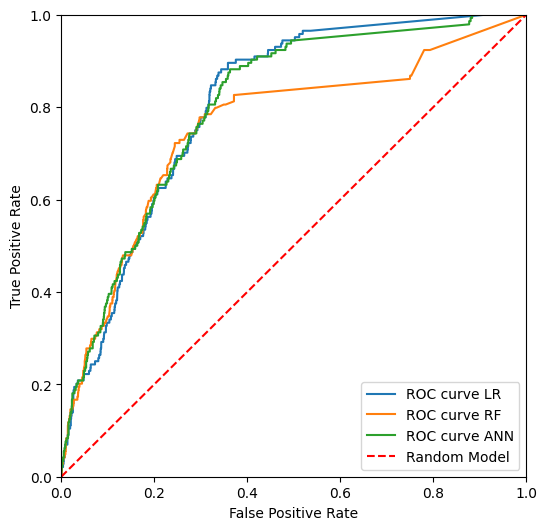

In [96]:
# compute ROC curve for logistic regression (LR)
false_positive_rate_lr, true_positive_rate_lr, threshold_lr = roc_curve(Y_test, churn_prob)

# compute ROC curve for random forest (RF)
false_positive_rate_rf, true_positive_rate_rf, threshold_rf = roc_curve(Y_test, churn_prob_rf)

# compute ROC curve for ann
false_positive_rate_ann, true_positive_rate_ann, threshold_ann = roc_curve(Y_test, churn_prob_ann)

# plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate_lr, true_positive_rate_lr, label='ROC curve LR') # plot curve LR
plt.plot(false_positive_rate_rf, true_positive_rate_rf, label='ROC curve RF') # plot curve RF
plt.plot(false_positive_rate_ann, true_positive_rate_ann, label='ROC curve ANN') # plot curve ann
plt.plot([0, 1], [0, 1],'r--', label='Random Model') # plot what randomly saying 0 or 1 would do (=diagonal)
plt.legend(loc='lower right') #plot legend
plt.xlim([0, 1]) 
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This is remarkable! While the **random forest** algorithm performs much better at 'common' thresholds, we also observe a drop in performance at much lower thresholds, the algorithm struggles heavily to identify the last churners in the test set, while the **logistic regression** is capable of detecting all churners (reaching upper part curve) at much lower thresholds. Let us use our **evaluation** function in these ranges:

In [97]:
# evaluate logistic regression model at 50% threshold
evaluation_function(0.1, evaluation_frame_lr)

true positives :45
false positive: 394
true negatives: 3850
false negatives: 99
accuracy: 0.8876481312670921
recall: 0.3125
precision: 0.10250569476082004


In [98]:
# evaluate random forest model at 50% threshold 
evaluation_function(0.1, evaluation_frame_rf)

true positives :48
false positive: 393
true negatives: 3851
false negatives: 96
accuracy: 0.8885597082953509
recall: 0.3333333333333333
precision: 0.10884353741496598


Our plot-based observations are confirmed. How would this translate into **AUC**?

In [99]:
# compute AUC for LR model
roc_auc_score(Y_test, churn_prob)

0.8059899924075818

In [100]:
# compute AUC for RF model
roc_auc_score(Y_test, churn_prob_rf)

0.7560093007121165

In [101]:
# compute AUC for ann model
roc_auc_score(Y_test, churn_prob_ann)

0.8016914402031627

Logistic regression is identified as better with regard to AUC. So which algorithm to select? Normally, the reaction would be to select the **best AUC score** (i.e., LR), but you have to think about your marketing campaign objectives! You will only contact the top N% of customers, and RF performs better in those situations! So we will use RF nonetheless, only for overly large churn campaigns (contacting half of the customer base), would the LR model be better But think about how expensive such a campaingn would be. When evaluating models, always think about different **evaluation metrics** and how they relate to your **business goals**(but i add ANN that is better than two of them)

## 5.2. Lift

Finally, we will evaluate our model in terms of the ``lift``. This measures how much the model performs better than a random model **for different chunks of data**. More specifically, the observations are **first sorted** by their predicted probability of being positive (in this case being successfully converted into a customer). Next, these observations will be **grouped into different chunks** (most often into percentiles with each percentile containing 1% of the observations). So the first chunk will contain observations with higher predicted probabilites than the second chunk and so on, meaning that the model is more certain for making positive predictions (i.e., target=1) in the first chunk than the second chunk and so on. So we can expect that the number of correctly identified positives in the first chunk will be higher than the second chunk and so on.
Finally, for each chunk, the model performance is **compared with the random model** by dividing the proportion of correctly identified positives with the general proportion of positives (which is the prediction of the random model). The result is a **lift score** for each chunk, indicating how much the model performs better than the random model for that particular chunk. 

For **example**: 
Suppose that there are 1000 companies in the test set and that the proportion of succesfully converted companies
equals 0.6.
First we will sort these companies by their predicted probability of being successfully converted into a customer.
Next we will split these ranked companies into percentiles, such that each chunk will contain 10 companies.
Now suppose that in the first chunk there are 9 companies of which the true label was 1 and 1 company of which the true label was 0. 
Then the lift score of this chunk is 0.9 / 0.6 = 1.5, meaning that the model is 1.5 times better than the random model for this chunk. 
Now suppose that in the second chunk there are only 7 companies of which the true label was 1 and 3 companies of which the true label was 0. 
Then the lift score of this chunk is 0.7 / 0.6 = 1.16, meaning that the model is 1.16 times better than the random model for this chunk.

Below you can find a visualization where the first chunk contains 9 companies of which the true label was 1 (and 2 companies of which the true label was 0).

In [116]:
label_pred= evaluation_frame_ann[['probabilty', 'actual_outcome']]

# sort DataFrame by predicted probability
label_pred = label_pred.sort_values(by="probabilty", ascending=False)
label_pred.columns=["prediction","TARGET"]

# check
label_pred.head(5)


,prediction,TARGET
14061,0.729460,1
13286,0.717404,1
10084,0.685744,0
14450,0.673320,0
8103,0.426847,0


In [117]:
# get global proportion of profitable customers in test set
prop_profitable_cust_test = label_pred["TARGET"].sum() / float(len(label_pred))
# check
print("Proportion of profitable customers: %s" %prop_profitable_cust_test)

Proportion of profitable customers: 0.032816773017319965


In [118]:
# calculate max lift
max_lift = 1. / prop_profitable_cust_test
# check
print("Max lift: %s" %max_lift)

Max lift: 30.47222222222222


In [119]:
# initialize list for storing lift scores 
lift_scores = []

# loop through percentiles
for i in reversed(range(100)):
    # divide dataframes into percentiles of predicted probabilities
    start_perc = label_pred["prediction"].quantile(i / 100.)
    end_perc = label_pred["prediction"].quantile((i+1) / 100.)
    chunk = label_pred[(label_pred["prediction"] >= start_perc) &  (label_pred["prediction"] < end_perc)]
    
    # get size of chunk
    chunk_size = len(chunk)
    
    # get proportion of profitable customers in chunk
    prop_profitable_cust_chunk = chunk["TARGET"].sum() / float(chunk_size)
    
    # divide by global proportion of profitable customors
    lift = prop_profitable_cust_chunk / prop_profitable_cust_test
    
    # add to lift list
    lift_scores.append(lift)

In [128]:
evaluation_frame_ann["expected_outcome"].value_counts()

expected_outcome
0    3510
1     878
Name: count, dtype: int64

In [122]:
label_pred["TARGET"].value_counts()

TARGET
0    4244
1     144
Name: count, dtype: int64

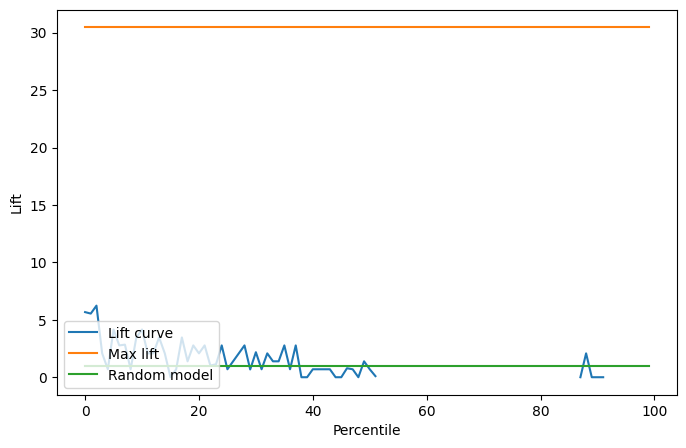

In [120]:
# plot lift curve
plt.figure(figsize=(8, 5))
plt.plot(range(100), lift_scores, label="Lift curve")
plt.plot(range(100), [max_lift for i in range(100)], label="Max lift")
plt.plot(range(100), [1 for i in range(100)], label="Random model")
plt.xlabel("Percentile")
plt.ylabel("Lift")
plt.legend(loc="lower left")
plt.show()

In [129]:
label_pred

,prediction,TARGET
14061,7.294596e-01,1
13286,7.174039e-01,1
10084,6.857440e-01,0
14450,6.733203e-01,0
8103,4.268469e-01,0
...,...,...
897,2.236158e-09,0
100,5.170068e-10,0
27,7.439270e-12,0
59,7.432093e-12,0


In [134]:
pip install scikit-plot


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [136]:
label_pred["prediction"]

14061    7.294596e-01
13286    7.174039e-01
10084    6.857440e-01
14450    6.733203e-01
8103     4.268469e-01
             ...     
897      2.236158e-09
100      5.170068e-10
27       7.439270e-12
59       7.432093e-12
951      7.374313e-12
Name: prediction, Length: 4388, dtype: float32

<Figure size 700x700 with 0 Axes>

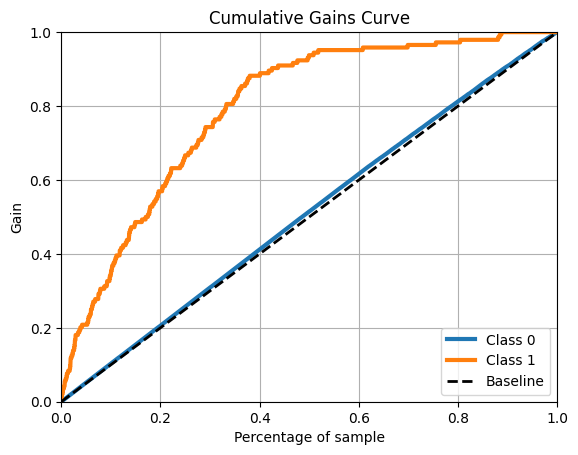

In [137]:
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt

# Assuming label_pred["prediction"] contains probabilities of the positive class
positive_probs = label_pred["prediction"]

# Create a 2D array: first column for class 0 (negative), second for class 1 (positive)
y_probas = np.vstack([1 - positive_probs, positive_probs]).T

# Now plot the cumulative gain chart
plt.figure(figsize=(7, 7))
skplt.metrics.plot_cumulative_gain(label_pred["TARGET"], y_probas)
plt.show()


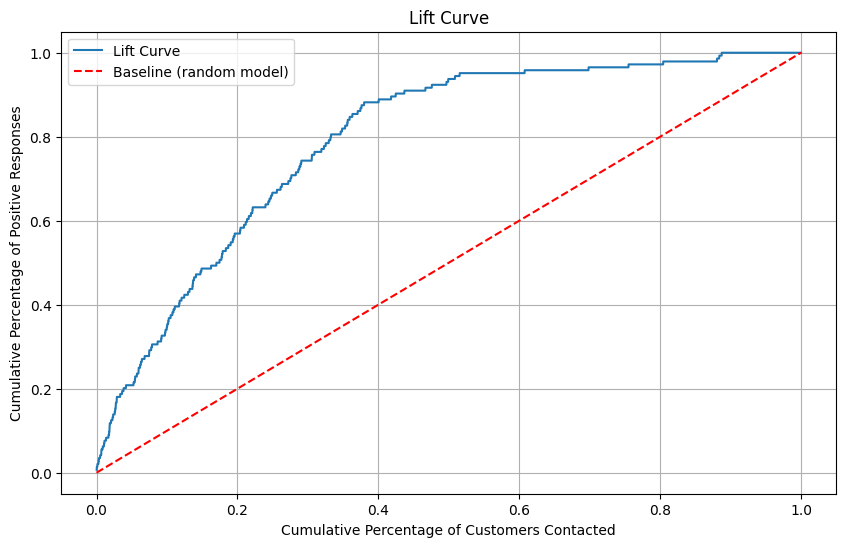

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming label_pred is your dataframe with columns "prediction" (predicted probabilities) and "TARGET" (actual labels)
# Sort by predicted probability in descending order
label_pred_sorted = label_pred.sort_values(by="prediction", ascending=False)

# Calculate cumulative sum of positive responses
label_pred_sorted['cumulative_positive'] = label_pred_sorted['TARGET'].cumsum()

# Total number of positive responses
total_positive_responses = label_pred_sorted['TARGET'].sum()

# Calculate cumulative percentage of positive responses
label_pred_sorted['cumulative_positive_percentage'] = label_pred_sorted['cumulative_positive'] / total_positive_responses

# Calculate cumulative percentage of customers contacted
label_pred_sorted['cumulative_customers_percentage'] = np.arange(1, len(label_pred_sorted) + 1) / len(label_pred_sorted)

# Plot the lift curve
plt.figure(figsize=(10, 6))
plt.plot(label_pred_sorted['cumulative_customers_percentage'], label_pred_sorted['cumulative_positive_percentage'], label='Lift Curve')
plt.plot([0, 1], [0, 1], 'r--', label='Baseline (random model)')
plt.title('Lift Curve')
plt.xlabel('Cumulative Percentage of Customers Contacted')
plt.ylabel('Cumulative Percentage of Positive Responses')
plt.legend()
plt.grid(True)
plt.show()
